# SENG 550 F2021 group 7 final project

### Members
- Jean-David Rousseau, 10157955
- Victor Sanchez Alarcon, 30054425
- Shamez Meghji, 30055991
- Owen Troke-Billard, 30046207

### Notebook contents
1. Dependencies
2. Import data
3. Clean data
4. Train model
5. Results

## 1. Dependencies

Install required PIP packages.

In [1]:
!pip install nltk==3.6.5
!pip install sklearn==0.0

Import dependencies.

In [2]:
import string
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, pow, abs, to_date, to_timestamp, min, max
from pyspark.sql.types import StringType, LongType
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Initialize Spark session.

In [3]:
spark = SparkSession \
    .builder \
    .getOrCreate()

Ivy Default Cache set to: /home/jovyan/.ivy2/cache

:: loading settings :: url = jar:file:/usr/local/spark-3.2.0-bin-hadoop3.2/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml



The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6d4f9856-0302-47eb-bcf4-109cb386b51d;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 258ms :: artifacts dl 9ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|e

## 2. Import data

Load cryptocurrency price data from MongoDB.

In [4]:
crypto_df = spark.read.format("mongo").option("uri","mongodb://mongo/seng550.crypto").load()
crypto_df.show(3)

+--------------------+------------------+----------+-----------------+
|                 _id|             close|      date|             open|
+--------------------+------------------+----------+-----------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23|60690.28731420007|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22|62196.96438572152|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21|65961.04976056097|
+--------------------+------------------+----------+-----------------+
only showing top 3 rows



Load news headlines from MongoDB.

In [5]:
headline_df = spark.read.format("mongo").option("uri", "mongodb://mongo/seng550.headers").load()
headline_df.show(3)

+--------------------+----------+--------------------+
|                 _id|      date|            headline|
+--------------------+----------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|
+--------------------+----------+--------------------+
only showing top 3 rows



## 3. Clean data

Compute the price change each day as a percentage.

In [6]:
crypto_df = crypto_df.withColumn('change', (col('close') / col('open')) - 1)
crypto_df.show(3)

+--------------------+------------------+----------+-----------------+--------------------+
|                 _id|             close|      date|             open|              change|
+--------------------+------------------+----------+-----------------+--------------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23|60690.28731420007|0.009034969351209954|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22|62196.96438572152|-0.02416459378776714|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21|65961.04976056097|-0.05553211730467056|
+--------------------+------------------+----------+-----------------+--------------------+
only showing top 3 rows



Convert string dates to date type.

In [7]:
crypto_df = crypto_df.withColumn('date', to_date(col('date')))
crypto_df.show(3)

+--------------------+------------------+----------+-----------------+--------------------+
|                 _id|             close|      date|             open|              change|
+--------------------+------------------+----------+-----------------+--------------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23|60690.28731420007|0.009034969351209954|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22|62196.96438572152|-0.02416459378776714|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21|65961.04976056097|-0.05553211730467056|
+--------------------+------------------+----------+-----------------+--------------------+
only showing top 3 rows



In [8]:
headline_df = headline_df.withColumn('date', to_date(col('date')))
headline_df.show(3)

+--------------------+----------+--------------------+
|                 _id|      date|            headline|
+--------------------+----------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|
+--------------------+----------+--------------------+
only showing top 3 rows



Pre-process news headlines. Punctuation is removed. Stop words are removed. Words are stemmed.

In [9]:
def clean_headline(headline):
    # Headers are small, so local process is ok.
    porter = PorterStemmer()
    headline = headline.strip()
    if not headline:
        return ''
    headline = headline.translate(str.maketrans('', '', string.punctuation))
    return ' '.join(porter.stem(word) for word in headline.split() if word not in ENGLISH_STOP_WORDS)

udf_clean_header = udf(lambda s: clean_headline(s), StringType())
headline_df = headline_df.withColumn('headline_clean', udf_clean_header(col('headline')))
headline_df.show(3)

+--------------------+----------+--------------------+--------------------+
|                 _id|      date|            headline|      headline_clean|
+--------------------+----------+--------------------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|famili speak raci...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|china invas taiwa...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|us digit payment ...|
+--------------------+----------+--------------------+--------------------+
only showing top 3 rows



Distribute price changes evenly across news headlines each day.

The training dataset does not attribute price changes to individual headlines. We approximate headline effects on price by attributing price changes to all headlines evenly. Distribution is done such that the product of all price changes attributed to individual headlines results in the original daily price change. Inaccuracies introduced by this approximation are mitigated by larger datasets.

In [10]:
date_count_df = headline_df.groupby('date').count()
crypto_headline_df = crypto_df.join(headline_df, on='date')\
    .join(date_count_df.withColumnRenamed('count', 'date_count'), on='date')\
    .withColumn('change_normalized', pow(1 + col('change'), 1 / col('date_count')) - 1)\
    .select('date', 'headline_clean', 'change_normalized')
crypto_headline_df.show(3)

+----------+--------------------+--------------------+
|      date|      headline_clean|   change_normalized|
+----------+--------------------+--------------------+
|2021-08-27|murray remind man...|0.004533092696482388|
|2021-08-27|ndp’ singh talk p...|0.004533092696482388|
|2021-08-27|rfk assassin sirh...|0.004533092696482388|
+----------+--------------------+--------------------+
only showing top 3 rows



## 4. Train model

Split the dataset into 80% train and 20% test partitions. The model is trained on the training partition and evaluated on the test partition. The partition is done by time because it is timeseries data.

In [11]:
train_fraction = 0.8

udf_unix_timestamp = udf(lambda date: int(date.strftime('%s')), LongType())
crypto_headline_df = crypto_headline_df.withColumn('unix_timestamp', udf_unix_timestamp(col('date')))
cutoff_timestamp = crypto_headline_df.approxQuantile('unix_timestamp', [train_fraction], 0)[0]

In [12]:
train_df = crypto_headline_df.where(col('unix_timestamp') <= cutoff_timestamp).drop('unix_timestamp')
train_df.show(3)
train_df.agg(min(col('date')), max(col('date'))).show()

+----------+--------------------+--------------------+
|      date|      headline_clean|   change_normalized|
+----------+--------------------+--------------------+
|2021-08-27|murray remind man...|0.004533092696482388|
|2021-08-27|ndp’ singh talk p...|0.004533092696482388|
|2021-08-27|rfk assassin sirh...|0.004533092696482388|
+----------+--------------------+--------------------+
only showing top 3 rows

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2021-03-01|2021-09-06|
+----------+----------+



In [13]:
test_df = crypto_headline_df.where(col('unix_timestamp') > cutoff_timestamp).drop('unix_timestamp')
test_df.show(3)
test_df.agg(min(col('date')), max(col('date'))).show()

+----------+--------------------+--------------------+
|      date|      headline_clean|   change_normalized|
+----------+--------------------+--------------------+
|2021-10-11|jesi nelson claim...|0.004835823570711...|
|2021-10-11|elect worker geor...|0.004835823570711...|
|2021-10-11|texa gov abbott i...|0.004835823570711...|
+----------+--------------------+--------------------+
only showing top 3 rows

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2021-09-07|2021-10-23|
+----------+----------+



Fit a TF-IDF vectorizer to the train data. The TF-IDF vectorizer knows how to convert pre-processed text into a sparse vector of TF-IDF values based on a learned vocabulary. All terms and inverse document frequencies (IDFs) are established by the training data. The model does not learn new terms that are introduced after this stage.

In [14]:
class TfidfModel:
    def __init__(self, tokenizer, cv_model, idf_model):
        self.tokenizer = tokenizer
        self.cv_model = cv_model
        self.idf_model = idf_model

# Use this prefix on temporary columns so they don't conflict with existing columns.
tfidf_comp_prefix = 'kfwsxy'

def fit_tfidf_model(df, input_col, output_col):
    tokenizer = Tokenizer(inputCol=input_col, outputCol=f'{tfidf_comp_prefix}_words')
    words_data = tokenizer.transform(df)

    cv = CountVectorizer(inputCol=f'{tfidf_comp_prefix}_words', outputCol=f'{tfidf_comp_prefix}_raw')
    cv_model = cv.fit(words_data)

    featurized_data = cv_model.transform(words_data)

    idf = IDF(inputCol=f'{tfidf_comp_prefix}_raw', outputCol=output_col)
    idf_model = idf.fit(featurized_data)

    return TfidfModel(tokenizer, cv_model, idf_model)

def tfidf_vectorize(df, tfidf_model):
    words_data = tfidf_model.tokenizer.transform(df)
    featurized_data = tfidf_model.cv_model.transform(words_data)
    res_df = tfidf_model.idf_model.transform(featurized_data)
    return res_df\
        .drop(f'{tfidf_comp_prefix}_words')\
        .drop(f'{tfidf_comp_prefix}_raw').drop('headline_clean')

tfidf_model = fit_tfidf_model(train_df, 'headline_clean', 'headline_features')

TF-IDF vectorize the training data. All headline terms will be encoded because the vectorizer vocabulary contains all training terms.

In [15]:
vectorized_train_df = tfidf_vectorize(train_df, tfidf_model)
vectorized_train_df.show(3)

+----------+--------------------+--------------------+
|      date|   change_normalized|   headline_features|
+----------+--------------------+--------------------+
|2021-08-27|0.004533092696482388|(5604,[28,267,540...|
|2021-08-27|0.004533092696482388|(5604,[75,143,146...|
|2021-08-27|0.004533092696482388|(5604,[38,56,80,1...|
+----------+--------------------+--------------------+
only showing top 3 rows



TF-IDF vectorize the test data. Headline terms not seen before will be dropped.

In [16]:
vectorized_test_df = tfidf_vectorize(test_df, tfidf_model)
vectorized_test_df.show(3)

+----------+--------------------+--------------------+
|      date|   change_normalized|   headline_features|
+----------+--------------------+--------------------+
|2021-10-11|0.004835823570711...|(5604,[54,292,346...|
|2021-10-11|0.004835823570711...|(5604,[225,233,26...|
|2021-10-11|0.004835823570711...|(5604,[0,4,15,143...|
+----------+--------------------+--------------------+
only showing top 3 rows



Denote columns that contain raw features (TF-IDF vector), attributed affect on price, and predicted affect on price, respectively.

In [17]:
features_col= 'headline_features'
label_col= 'change_normalized'
prediction_col = 'change_prediction'

Fit a ridge regression model to the training data. The ridge λ hyperparameter is tuned by trying many possibilities and selecting the best. Cross validation is used to ensure an accurate performance measure is determined for each λ tested. The training data is further segmented into train and validation partitions on each cross validation k-fold.

This cell runs very slowly. If you do not care about accuracy, set:
- `num_folds = 2`
- `num_lambda = 2`

In [18]:
num_folds = 3
num_lambda = 50

reg_params = np.linspace(0.02, 0.04, num_lambda)

lr_base = LinearRegression(
    elasticNetParam=0,
    featuresCol=features_col,
    labelCol=label_col,
    predictionCol=prediction_col)

pipeline = Pipeline(stages=[lr_base])

param_grid = ParamGridBuilder()\
    .addGrid(lr_base.regParam, reg_params)\
    .build()

pipeline_evaluator = RegressionEvaluator(
    labelCol=label_col,
    predictionCol=prediction_col)

cross_val = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=pipeline_evaluator,
    numFolds=num_folds,
    parallelism=8)

lr = cross_val.fit(vectorized_train_df)

21/12/19 13:55:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/19 13:55:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/19 13:55:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/19 13:55:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/12/19 13:59:51 WARN BlockManager: Asked to remove block broadcast_1942, which does not exist
21/12/19 14:02:36 WARN BlockManager: Asked to remove block broadcast_3245_piece0, which does not exist
21/12/19 14:02:36 WARN BlockManager: Asked to remove block broadcast_3245, which does not exist
21/12/19 14:04:20 WARN BlockManager: Asked to remove block broadcast_4096, which does not exist
21/12/19 14:09:21 WARN BlockManager: Asked to remove block broadcast_6485, which does not exist
21/12/19 14:10:05 WARN BlockManager: Asked to remove blo

Graph the performance of all ridge λ hyperparameters tested. The value yielding the lowest error is the best.

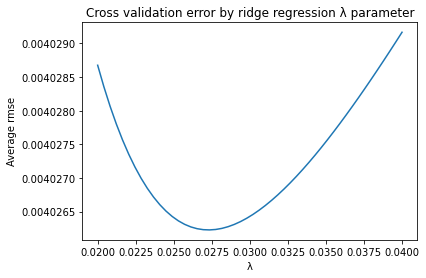

In [19]:
x_label = 'λ'
y_label = 'Average ' + pipeline_evaluator.getMetricName()
tune_result_df = pd.DataFrame({
    x_label: reg_params,
    y_label: lr.avgMetrics})\
    .set_index(['λ'])
plot = tune_result_df.plot.line(
    title='Cross validation error by ridge regression λ parameter',
    ylabel=y_label,
    legend=False)

## 5. Results

### Daily price change statistics

In [20]:
crypto_df.describe('change').show(truncate=False)

+-------+---------------------+
|summary|change               |
+-------+---------------------+
|count  |301                  |
|mean   |0.0037206674963974834|
|stddev |0.04336846404173201  |
|min    |-0.13719500387926653 |
|max    |0.18962753904801044  |
+-------+---------------------+



### Daily price change percentiles

In [21]:
percentiles = ['1.00', '0.99', '0.95', '0.90', '0.10', '0.05', '0.01', '0.00']
percentile_changes = crypto_df.approxQuantile('change', list(map(lambda p: float(p), percentiles)), 0)
spark.createDataFrame(zip(percentiles, percentile_changes), ['percentile', 'change']).show(truncate=False)

+----------+--------------------+
|percentile|change              |
+----------+--------------------+
|1.00      |0.18962753904801044 |
|0.99      |0.10008718462196198 |
|0.95      |0.07710582175138714 |
|0.90      |0.05851235330945315 |
|0.10      |-0.04542700888832041|
|0.05      |-0.06622526152319208|
|0.01      |-0.10986854225982423|
|0.00      |-0.13719500387926653|
+----------+--------------------+



### Sample of predictions made with training data

In [22]:
train_prediction_df = lr.transform(vectorized_train_df)
train_prediction_df.show(3)

+----------+--------------------+--------------------+--------------------+
|      date|   change_normalized|   headline_features|   change_prediction|
+----------+--------------------+--------------------+--------------------+
|2021-08-27|0.004533092696482388|(5604,[28,267,540...|0.001383638163324...|
|2021-08-27|0.004533092696482388|(5604,[75,143,146...|0.001493497027315...|
|2021-08-27|0.004533092696482388|(5604,[38,56,80,1...|0.001248385085457505|
+----------+--------------------+--------------------+--------------------+
only showing top 3 rows



### Sample of predictions made with test data

In [23]:
test_prediction_df = lr.transform(vectorized_test_df)
test_prediction_df.show(3)

+----------+--------------------+--------------------+--------------------+
|      date|   change_normalized|   headline_features|   change_prediction|
+----------+--------------------+--------------------+--------------------+
|2021-10-11|0.004835823570711...|(5604,[54,292,346...|-1.65510295534941...|
|2021-10-11|0.004835823570711...|(5604,[225,233,26...|-7.93669085763598...|
|2021-10-11|0.004835823570711...|(5604,[0,4,15,143...|1.340928818004930...|
+----------+--------------------+--------------------+--------------------+
only showing top 3 rows



### Training errors

In [24]:
def lr_evaluator(metric_name):
    return RegressionEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
        metricName=metric_name)

def evaluate_lr(prediction_df, metrics=None):
    if metrics is None:
        metrics = ['rmse', 'mse', 'mae', 'var']
    scores = {}
    for metric in metrics:
        evaluator = lr_evaluator(metric)
        scores[metric] = evaluator.evaluate(prediction_df)
    df = spark.createDataFrame(scores.items(), ['metric', 'score'])
    return df

evaluate_lr(train_prediction_df).show(truncate=False)

+------+---------------------+
|metric|score                |
+------+---------------------+
|rmse  |0.00294464627932664  |
|mse   |8.670941710352224E-6 |
|mae   |0.002190221026268835 |
|var   |1.7113990892798612E-6|
+------+---------------------+



### Test errors

In [25]:
evaluate_lr(test_prediction_df).show(truncate=False)

+------+---------------------+
|metric|score                |
+------+---------------------+
|rmse  |0.004099228106753644 |
|mse   |1.6803671071199066E-5|
|mae   |0.003093483663133763 |
|var   |3.6181254662511546E-7|
+------+---------------------+



### Top 10 terms by coefficient magnitude

In [26]:
lr_inner = lr.bestModel.stages[0]
coefficients_zip = zip(
    tfidf_model.cv_model.vocabulary,
    map(lambda x: float(x), lr_inner.coefficients))
coefficients_df = spark.createDataFrame(coefficients_zip, ['term', 'coefficient'])

coefficients_df\
    .withColumn('coefficient_magnitude', abs('coefficient'))\
    .orderBy('coefficient_magnitude', ascending=False)\
    .drop('coefficient_magnitude')\
    .show(10, truncate=False)

+---------+----------------------+
|term     |coefficient           |
+---------+----------------------+
|5192021  |-2.5185426917111604E-4|
|palestin |-2.3570046340583574E-4|
|911style |-2.3457053779743988E-4|
|thailand |-2.2654285117778376E-4|
|conclus  |-2.2654285117778376E-4|
|progress |-2.2153066821313806E-4|
|karachi  |-2.204231803455027E-4 |
|delimit  |-2.1923145088195237E-4|
|22000    |-2.183843406637916E-4 |
|showerher|-2.1625026279133096E-4|
+---------+----------------------+
only showing top 10 rows



### Term coefficient statistics

In [27]:
coefficients_df.describe('coefficient').show(truncate=False)

+-------+----------------------+
|summary|coefficient           |
+-------+----------------------+
|count  |5604                  |
|mean   |9.210015398950445E-7  |
|stddev |4.88742783387291E-5   |
|min    |-2.5185426917111604E-4|
|max    |2.006809192424979E-4  |
+-------+----------------------+

